In [1]:
import numpy as np

In [2]:
with open('../data/Korean_movie_reviews_2016.txt', encoding='utf-8') as f:
    docs = [doc.strip().split('\t') for doc in f]
    docs = [(doc[0], int(doc[1])) for doc in docs if len(doc) == 2]
    texts, labels = zip(*docs)

In [3]:
words_list = [doc.strip().split() for doc in texts]
# 각 문서를 단어들의 리스트 형태로 표현

In [4]:
total_words = []
for words in words_list:
    total_words.extend(words)

In [5]:
from collections import Counter
c = Counter(total_words)

In [6]:
vocab_size  = 20000
common_words = [ word for word, count in c.most_common(vocab_size )]
# 빈도를 기준으로 상위 10000개의 단어들만 선택

In [7]:
words_dic ={}
# 각 단어에 대해서 index 생성하기
for index, word in enumerate(common_words):
    words_dic[word]=index+1
    # 각 단어의 index는 1부터 시작
    # 0은 패딩을 위해 사용하지 않음

In [8]:
# 각 문서를 상위 20000개 단어들에 대해서 index 번호로 표현하기
filtered_indexed_words = []
for review in words_list:
    indexed_words=[]
    for word in review:
        try:
            indexed_words.append(words_dic[word])
        except:
            pass
    filtered_indexed_words.append(indexed_words)

In [9]:
maxlen = 40
# 각 영화평의 길이를 40으로 통일 

In [10]:
from tensorflow.keras.preprocessing import sequence
X = sequence.pad_sequences(filtered_indexed_words, maxlen=maxlen)

In [11]:
from tensorflow.keras.utils import to_categorical
y_one_hot = to_categorical(labels)

In [12]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.1)

In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [14]:
class EncoderBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
#         super(EncoderBlock, self).__init__()
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [15]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
#         super(TokenAndPositionEmbedding, self).__init__()
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [16]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size+1, embed_dim)
x = embedding_layer(inputs)
x = EncoderBlock(embed_dim, num_heads, ff_dim)(x)
x = EncoderBlock(embed_dim, num_heads, ff_dim)(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40)]              0         
                                                                 
 token_and_position_embeddin  (None, 40, 32)           641312    
 g (TokenAndPositionEmbeddin                                     
 g)                                                              
                                                                 
 encoder_block (EncoderBlock  (None, 40, 32)           10656     
 )                                                               
                                                                 
 encoder_block_1 (EncoderBlo  (None, 40, 32)           10656     
 ck)                                                             
                                                                 
 global_average_pooling1d (G  (None, 32)               0     

In [18]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

In [19]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
checkpoint_filepath = './temp/checkpoint_tr_kr'
mc = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', mode='min', 
                     save_weights_only=True, save_best_only=True)

In [20]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics="accuracy")

In [21]:
history = model.fit(X_train, y_train, epochs=20, batch_size=128, validation_split=0.1, callbacks=[es, mc])

Epoch 1/20
1047/1047 [==============================] - 45s 41ms/step - loss: 0.3121 - accuracy: 0.8651 - val_loss: 0.2470 - val_accuracy: 0.9004
Epoch 2/20
1047/1047 [==============================] - 43s 41ms/step - loss: 0.2117 - accuracy: 0.9169 - val_loss: 0.2893 - val_accuracy: 0.8866
Epoch 3/20
1047/1047 [==============================] - 43s 41ms/step - loss: 0.1759 - accuracy: 0.9309 - val_loss: 0.2853 - val_accuracy: 0.8969
Epoch 4/20
1047/1047 [==============================] - 43s 41ms/step - loss: 0.1466 - accuracy: 0.9422 - val_loss: 0.3124 - val_accuracy: 0.8907
Epoch 4: early stopping


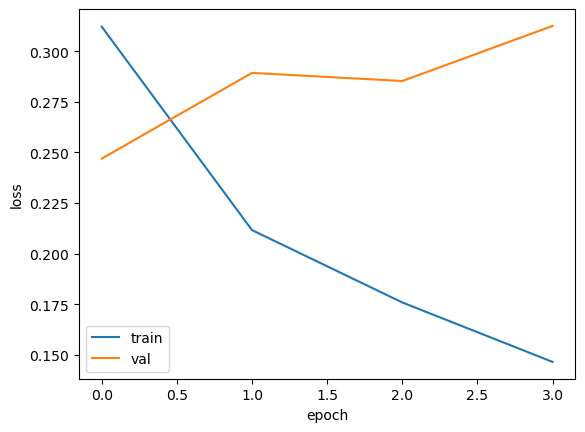

In [22]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [23]:
model.load_weights(checkpoint_filepath)

In [24]:
test_loss, test_acc = model.evaluate(X_test,y_test)

517/517 [==============================] - 2s 4ms/step - loss: 0.2411 - accuracy: 0.9013


In [25]:
test_acc

0.9012636542320251